# Compas data analysis

*The COMPAS dataset, analyzed here, was compiled by ProPublica for their 2016 "Machine Bias" investigation into the fairness of the COMPAS recidivism risk assessment tool, developed by Northpointe (Equivant). Obtained via a public records request from the Broward County Sheriff’s Office in Florida, it includes data on defendants screened by COMPAS between 2013 and 2014, with recidivism outcomes tracked over two years. After cleaning—removing cases with mismatched dates, missing COMPAS records, or minor traffic offenses—the dataset contains 6172 defendants from Broward County, a diverse urban area. It captures criminal history, demographics, and COMPAS scores for individuals facing felony (64.8%) or misdemeanor (35.2%) charges. The population is predominantly male (80.9%), with a mean age of 34.8 years (57.3% aged 25-45), and racially diverse: 51.4% African-American, 34.1% Caucasian, 8.2% Hispanic, and 5.6% Other. Prior offenses average 3.2 (median 1), with juvenile records minimal (e.g., mean juvenile felonies 0.07). The two-year recidivism rate is 45.1% overall, varying by race (e.g., 51.4% African-American, 39.3% Caucasian), while mean COMPAS decile scores (1-10) are 4.4 overall, higher for African-Americans (5.4) than Caucasians (3.5). This dataset, focused on a regional justice system sample, is widely used to explore algorithmic fairness.*



In [1]:
# Python equivalent of COMPAS analysis notebook using common Python libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter

# Load dataset
# df = pd.read_csv("https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv")
# df.to_csv("compas-scores-two-years.csv", index=False)
df = pd.read_csv("./compas-scores-two-years.csv")
# df = pd.read_csv("./compas-scores-two-years.csv")



In [2]:
df[["sex", "race", "age", "dob", "age_cat", "decile_score", "two_year_recid"]][:10]


,sex,race,age,dob,age_cat,decile_score,two_year_recid
0,Male,Other,69,1947-04-18,Greater than 45,1,0
1,Male,African-American,34,1982-01-22,25 - 45,3,1
2,Male,African-American,24,1991-05-14,Less than 25,4,1
3,Male,African-American,23,1993-01-21,Less than 25,8,0
4,Male,Other,43,1973-01-22,25 - 45,1,0
5,Male,Other,44,1971-08-22,25 - 45,1,0
6,Male,Caucasian,41,1974-07-23,25 - 45,6,1
7,Male,Other,43,1973-02-25,25 - 45,4,0
8,Female,Caucasian,39,1976-06-03,25 - 45,1,0
9,Male,Caucasian,21,1994-06-10,Less than 25,3,1


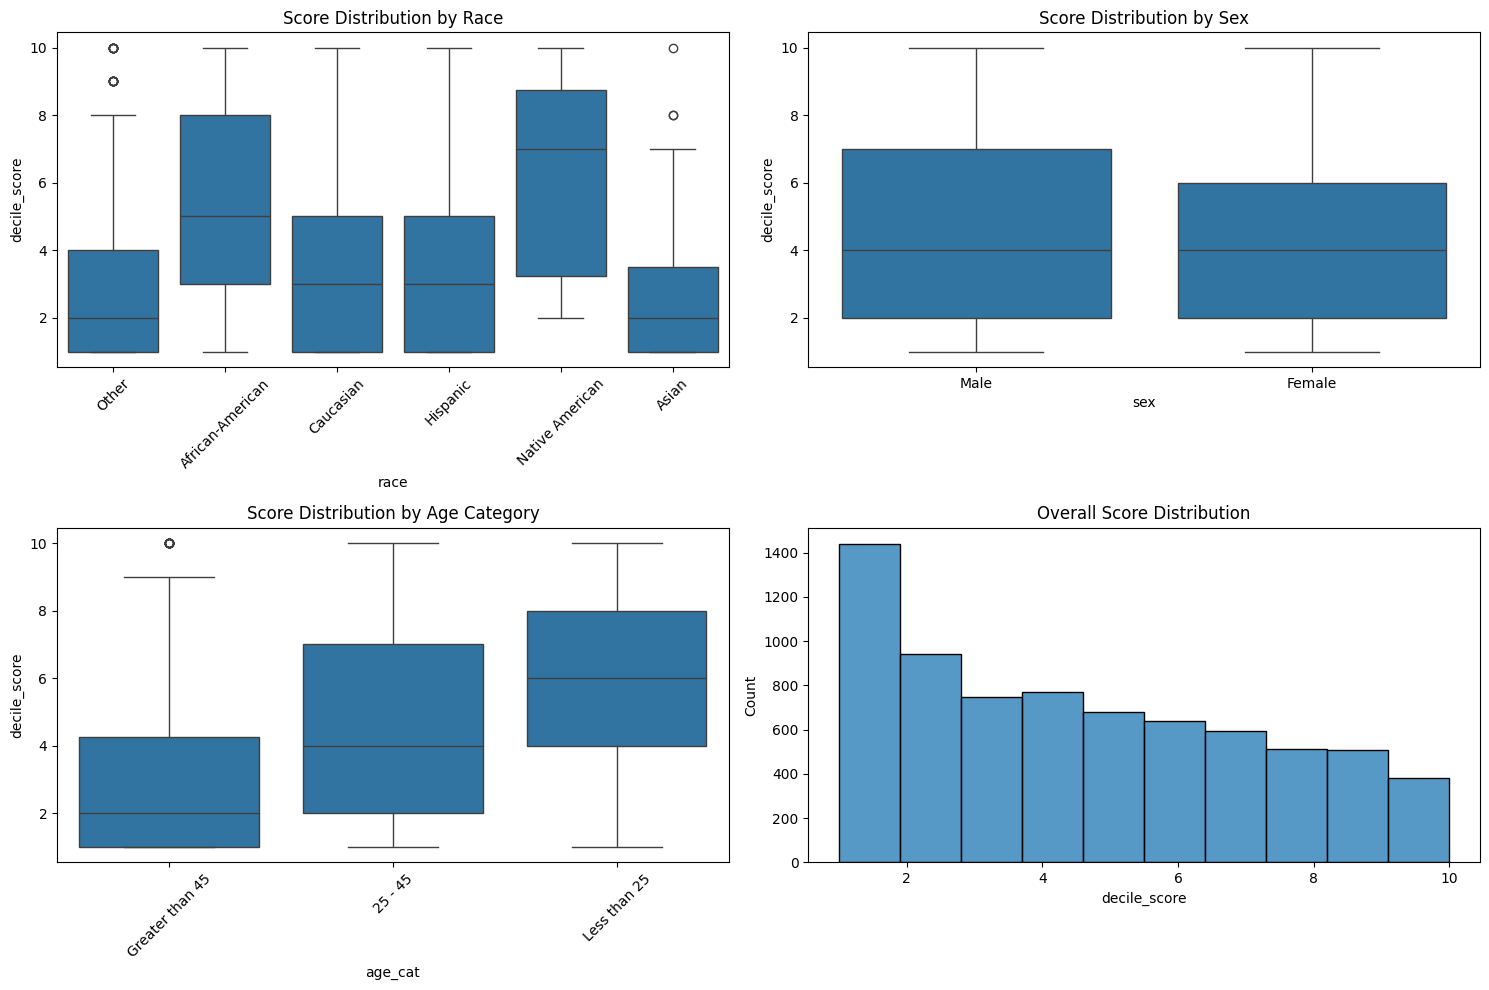


Mean Scores by Race:
race
African-American    5.368777
Asian               2.937500
Caucasian           3.735126
Hispanic            3.463108
Native American     6.166667
Other               2.949602
Name: decile_score, dtype: float64

Mean Scores by Sex:
sex
Female    4.172043
Male      4.590479
Name: decile_score, dtype: float64

Mean Scores by Age Category:
age_cat
25 - 45            4.599659
Greater than 45    2.917513
Less than 25       5.908437
Name: decile_score, dtype: float64


In [3]:
# Create visualizations for score distributions across protected attributes
plt.figure(figsize=(15, 10))

# Plot 1: Distribution by Race
plt.subplot(2, 2, 1)
sns.boxplot(x='race', y='decile_score', data=df)
plt.xticks(rotation=45)
plt.title('Score Distribution by Race')

# Plot 2: Distribution by Sex
plt.subplot(2, 2, 2)
sns.boxplot(x='sex', y='decile_score', data=df)
plt.title('Score Distribution by Sex')

# Plot 3: Distribution by Age Category
plt.subplot(2, 2, 3)
sns.boxplot(x='age_cat', y='decile_score', data=df)
plt.xticks(rotation=45)
plt.title('Score Distribution by Age Category')

# Plot 4: Score Distribution Overall
plt.subplot(2, 2, 4)
sns.histplot(data=df, x='decile_score', bins=10)
plt.title('Overall Score Distribution')

plt.tight_layout()
plt.show()

# Calculate summary statistics for each protected group
print("\nMean Scores by Race:")
print(df.groupby('race')['decile_score'].mean())

print("\nMean Scores by Sex:")
print(df.groupby('sex')['decile_score'].mean())

print("\nMean Scores by Age Category:")
print(df.groupby('age_cat')['decile_score'].mean())

## COMPAS Dataset: Origin and Population

The COMPAS dataset, specifically the `compas-scores-two-years.csv` file with 6172 observations, is a cleaned subset of data compiled by ProPublica for their 2016 investigation titled **"Machine Bias,"** published on May 23, 2016. ProPublica, a nonprofit investigative journalism organization, used this dataset to evaluate the fairness of the Correctional Offender Management Profiling for Alternative Sanctions (COMPAS) risk assessment tool, developed by Northpointe (now Equivant), which predicts recidivism risk in U.S. courts. Below is how the dataset was obtained and the population it represents.

### How the Dataset Was Obtained

- **Initial Data Collection**:
  - ProPublica acquired raw data from the **Broward County Sheriff’s Office** in Florida through a public records request.
  - This data included COMPAS risk scores (general and violent recidivism), criminal history, jail/prison time, and demographic details for defendants screened in **2013-2014**.
  - The original raw dataset is stored as `compas.db`, a SQLite database containing comprehensive records.

- **Data Cleaning and Processing**:
  - ProPublica processed the raw data to create `compas-scores-two-years.csv`, focusing on a two-year recidivism follow-up. They applied the following filters:
    - **Time Window**: Excluded cases where the COMPAS-scored crime’s charge date was more than 30 days from the arrest date (`days_b_screening_arrest` > 30 or < -30), indicating potential data mismatches.
    - **Recidivism Flag**: Removed entries with `is_recid` = -1 (no matching COMPAS case in records).
    - **Charge Type**: Dropped ordinary traffic offenses (`c_charge_degree` = 'O'), which were minimal (2 cases) and rarely led to jail time.
    - **Two-Year Outcome**: Retained only defendants who either recidivated within two years or had at least two years outside a correctional facility without reoffending, verified via Broward County public criminal records.
  - The cleaned dataset resulted in **6172 defendants**, aligning COMPAS predictions (`decile_score`) with actual two-year recidivism outcomes (`two_year_recid`).

- **Source Context**:
  - Data spans COMPAS screenings from **2013-2014**, with recidivism tracked through **2015-2016**.
  - Broward County was chosen because it actively used COMPAS in pretrial and sentencing decisions, providing a real-world application context.

### Population Included

- **Geographic Scope**: The dataset represents individuals processed through the criminal justice system in **Broward County, Florida**, a large jurisdiction in the U.S. Southeast (population ~1.8 million in 2010s).
- **Defendant Population**:
  - Includes **pretrial defendants** screened by COMPAS, typically at the point of arrest or booking, to assess recidivism risk for bail or sentencing decisions.
  - Covers a mix of **felony** (64.8%) and **misdemeanor** (35.2%) charges, excluding minor traffic offenses after filtering.
- **Demographics**:
  - **Race**: Predominantly African-American (51.4%) and Caucasian (34.1%), with smaller groups like Hispanic (8.2%), Other (5.6%), Asian (0.5%), and Native American (0.2%).
  - **Sex**: Mostly male (80.9%), with females at 19.1%.
  - **Age**: Mean age ~34.8 years, with 57.3% aged 25-45, 22% under 25, and 20.7% over 45.
- **Criminal History**: Varied, with a mean of 3.2 prior adult offenses (range 0-38) and low juvenile offense counts (e.g., mean juvenile felonies ~0.07).
- **Recidivism Focus**: Tracks individuals with at least two years of follow-up data, capturing a 45.1% overall two-year recidivism rate, with variation by race (e.g., 51.4% African-American, 39.3% Caucasian).

### Key Notes

- This dataset reflects a **specific legal and temporal context**: Broward County’s use of COMPAS in 2013-2014, with outcomes extending to 2016.
- It’s a **cleaned subset**, not the full population screened by COMPAS, designed to test the tool’s predictive accuracy and fairness over two years.
- The focus on recidivism within two years aligns with COMPAS’s intended prediction window, making it suitable for fairness analyses like racial bias assessments.

Dataset Overview:
Total Defendants: 7214

Demographics:
Race Distribution:
  African-American: 3696 (51.2%)
  Caucasian: 2454 (34.0%)
  Hispanic: 637 (8.8%)
  Other: 377 (5.2%)
  Asian: 32 (0.4%)
  Native American: 18 (0.2%)


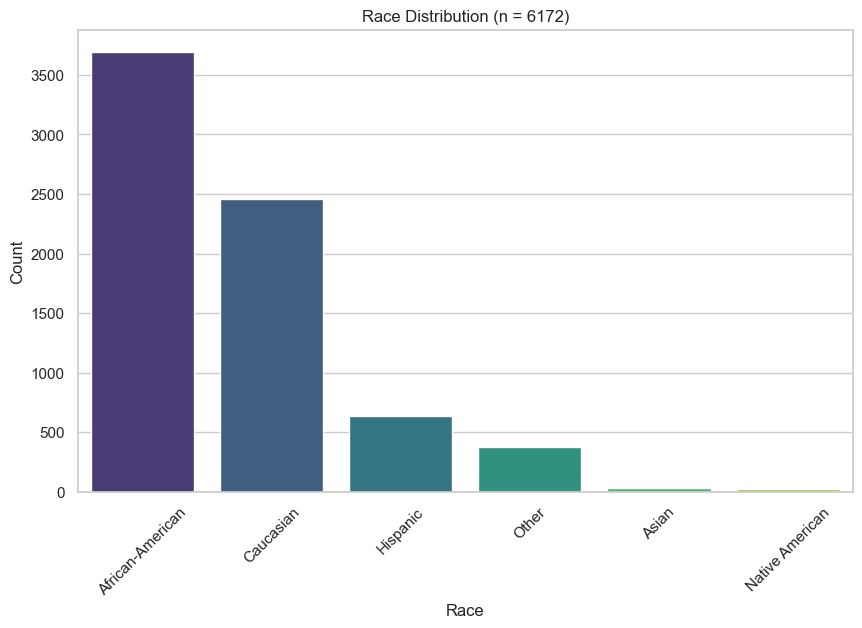

Sex Distribution:
  Male: 5819 (80.7%)
  Female: 1395 (19.3%)


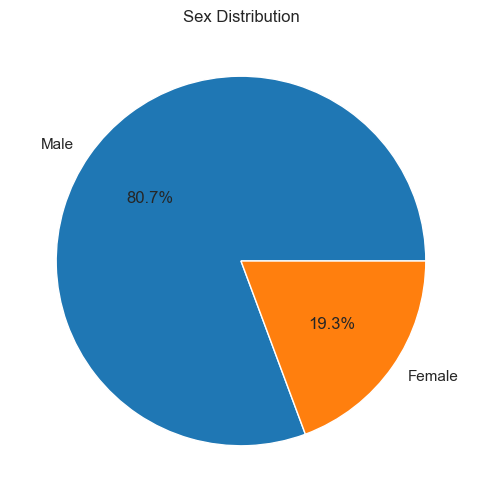

Mean Age: 34.8 years
Median Age: 31 years
Age Category Distribution:
  25 - 45: 4109 (57.0%)
  Greater than 45: 1576 (21.8%)
  Less than 25: 1529 (21.2%)


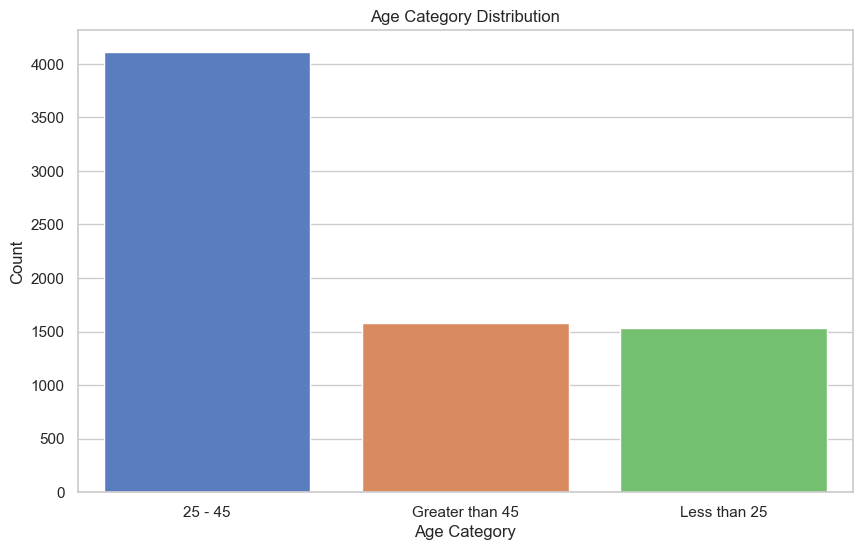

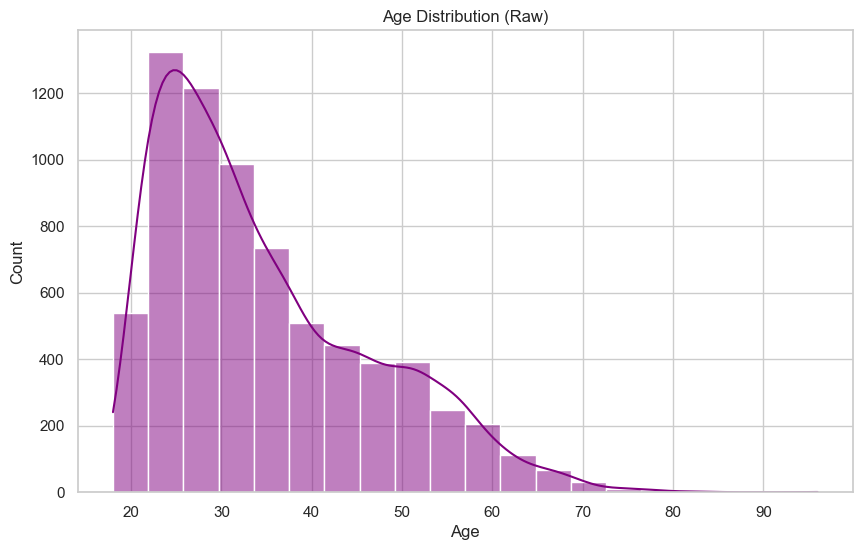

Criminal History:
Mean Prior Offenses (Adult): 3.5
Median Prior Offenses (Adult): 2
Range of Prior Offenses: 0 - 38


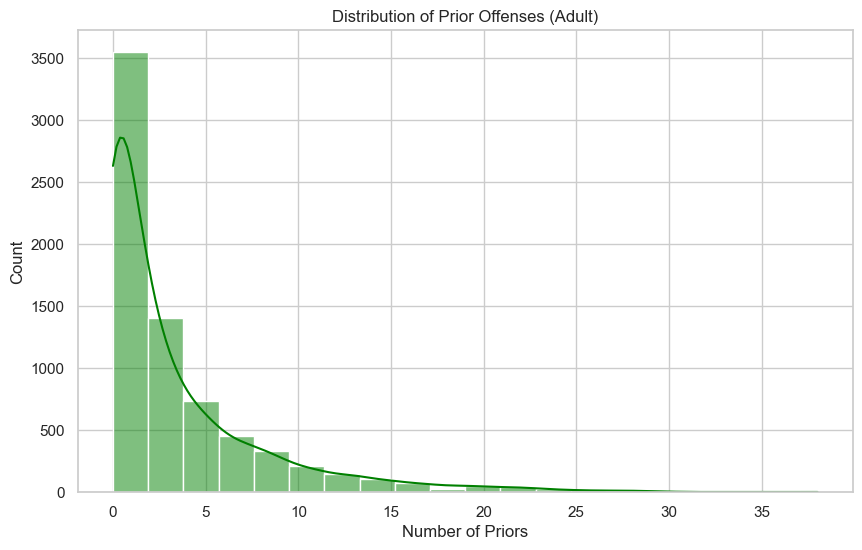

Mean Juvenile Felonies: 0.07
Mean Juvenile Misdemeanors: 0.09
Mean Other Juvenile Offenses: 0.11


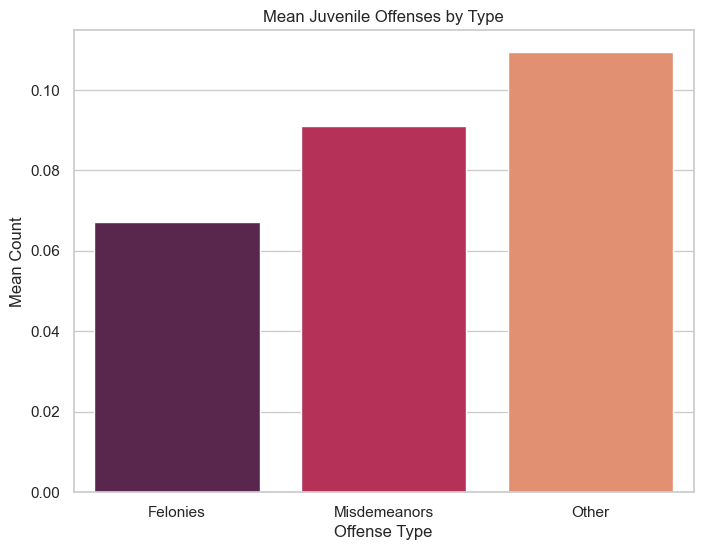

Current Charge Degree:
  F: 4666 (64.7%)
  M: 2548 (35.3%)


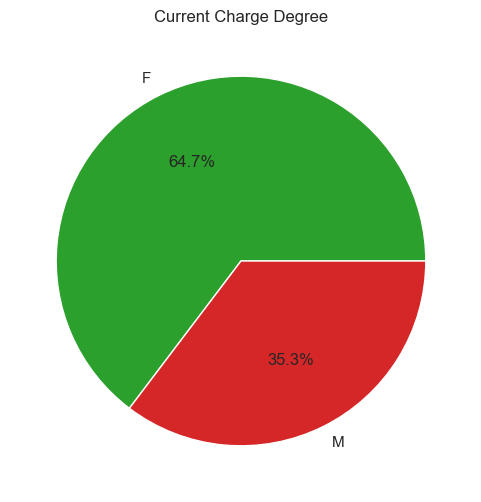

Recidivism Outcomes:
Overall Two-Year Recidivism Rate: 45.1%
Two-Year Recidivism Rate by Race:
  African-American: 51.4%
  Asian: 28.1%
  Caucasian: 39.4%
  Hispanic: 36.4%
  Native American: 55.6%
  Other: 35.3%


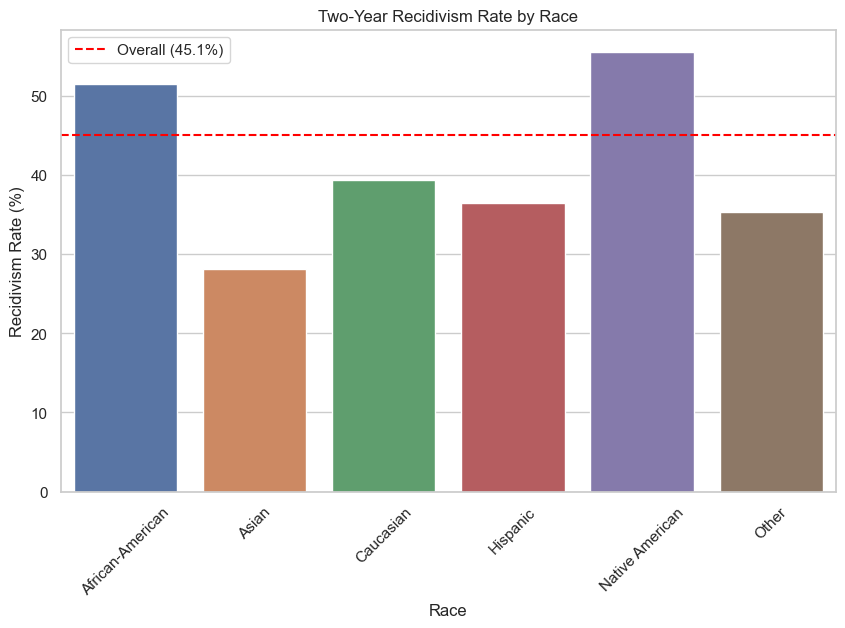

Mean Decile Score (General): 4.5
Median Decile Score (General): 4
Mean Decile Score by Race:
  African-American: 5.4
  Asian: 2.9
  Caucasian: 3.7
  Hispanic: 3.5
  Native American: 6.2
  Other: 2.9


/var/folders/tb/hcgb8y4j1xz6h647gc988q980000gn/T/ipykernel_23076/1918684653.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='race', y='decile_score', data=df, palette="coolwarm")


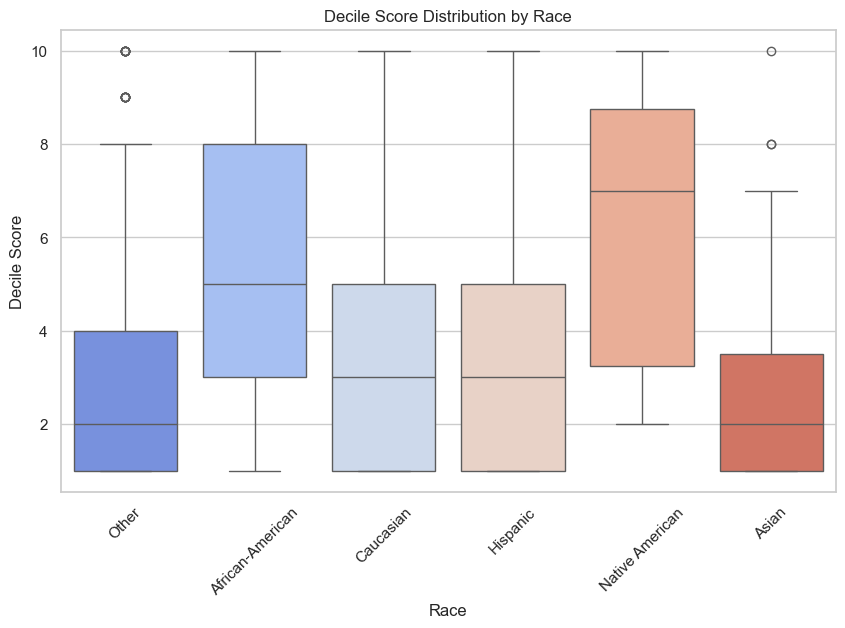

Violent Recidivism Outcomes:
Overall Violent Recidivism Rate: 11.4%
Mean Violent Decile Score: 3.7


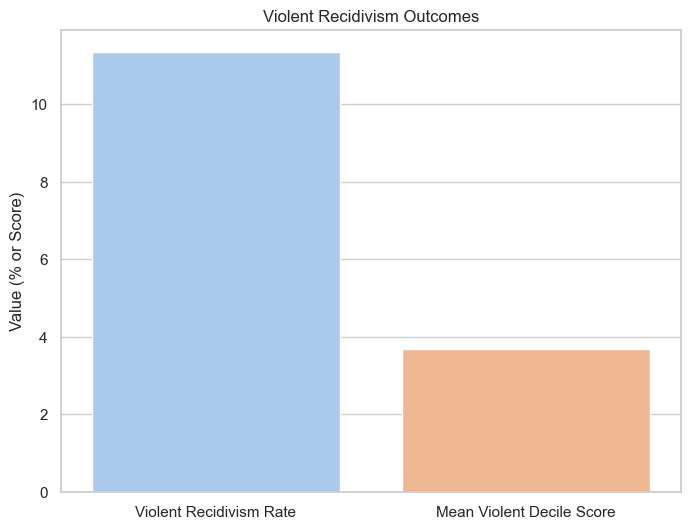

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
# df = pd.read_csv('compas-scores-two-years.csv')

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# 1. Dataset Size
print("Dataset Overview:")
print(f"Total Defendants: {len(df)}")
print()

# 2. Demographics
print("Demographics:")
# Race
race_counts = df['race'].value_counts()
race_percents = df['race'].value_counts(normalize=True) * 100
print("Race Distribution:")
for race, count, percent in zip(race_counts.index, race_counts, race_percents):
    print(f"  {race}: {count} ({percent:.1f}%)")
plt.figure(figsize=(10, 6))
sns.barplot(x=race_counts.index, y=race_counts.values, hue=race_counts.index, palette="viridis", legend=False)
plt.title('Race Distribution (n = 6172)')
plt.xlabel('Race')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Sex
sex_counts = df['sex'].value_counts()
sex_percents = df['sex'].value_counts(normalize=True) * 100
print("Sex Distribution:")
for sex, count, percent in zip(sex_counts.index, sex_counts, sex_percents):
    print(f"  {sex}: {count} ({percent:.1f}%)")
plt.figure(figsize=(6, 6))
plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', colors=['#1f77b4', '#ff7f0e'])
plt.title('Sex Distribution')
plt.show()

# Age
print(f"Mean Age: {df['age'].mean():.1f} years")
print(f"Median Age: {df['age'].median():.0f} years")
age_cat_counts = df['age_cat'].value_counts()
print("Age Category Distribution:")
for cat, count in age_cat_counts.items():
    print(f"  {cat}: {count} ({count / len(df) * 100:.1f}%)")
plt.figure(figsize=(10, 6))
sns.barplot(x=age_cat_counts.index, y=age_cat_counts.values, hue=age_cat_counts.index, palette="muted", legend=False)
plt.title('Age Category Distribution')
plt.xlabel('Age Category')
plt.ylabel('Count')
plt.show()
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=20, kde=True, color='purple')
plt.title('Age Distribution (Raw)')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# 3. Criminal History
print("Criminal History:")
print(f"Mean Prior Offenses (Adult): {df['priors_count'].mean():.1f}")
print(f"Median Prior Offenses (Adult): {df['priors_count'].median():.0f}")
print(f"Range of Prior Offenses: {df['priors_count'].min()} - {df['priors_count'].max()}")
plt.figure(figsize=(10, 6))
sns.histplot(df['priors_count'], bins=20, kde=True, color='green')
plt.title('Distribution of Prior Offenses (Adult)')
plt.xlabel('Number of Priors')
plt.ylabel('Count')
plt.show()

print(f"Mean Juvenile Felonies: {df['juv_fel_count'].mean():.2f}")
print(f"Mean Juvenile Misdemeanors: {df['juv_misd_count'].mean():.2f}")
print(f"Mean Other Juvenile Offenses: {df['juv_other_count'].mean():.2f}")
juv_means = [df['juv_fel_count'].mean(), df['juv_misd_count'].mean(), df['juv_other_count'].mean()]
juv_labels = ['Felonies', 'Misdemeanors', 'Other']
plt.figure(figsize=(8, 6))
sns.barplot(x=juv_labels, y=juv_means, hue=juv_labels, palette="rocket", legend=False)
plt.title('Mean Juvenile Offenses by Type')
plt.xlabel('Offense Type')
plt.ylabel('Mean Count')
plt.show()

# 4. Current Charge
charge_counts = df['c_charge_degree'].value_counts()
print("Current Charge Degree:")
for degree, count in charge_counts.items():
    print(f"  {degree}: {count} ({count / len(df) * 100:.1f}%)")
plt.figure(figsize=(6, 6))
plt.pie(charge_counts, labels=charge_counts.index, autopct='%1.1f%%', colors=['#2ca02c', '#d62728'])
plt.title('Current Charge Degree')
plt.show()

# 5. Recidivism Outcomes
print("Recidivism Outcomes:")
overall_recid_rate = df['two_year_recid'].mean() * 100
print(f"Overall Two-Year Recidivism Rate: {overall_recid_rate:.1f}%")
recid_by_race = df.groupby('race')['two_year_recid'].mean() * 100
print("Two-Year Recidivism Rate by Race:")
for race, rate in recid_by_race.items():
    print(f"  {race}: {rate:.1f}%")
plt.figure(figsize=(10, 6))
sns.barplot(x=recid_by_race.index, y=recid_by_race.values, hue=recid_by_race.index, palette="deep", legend=False)
plt.axhline(y=overall_recid_rate, color='red', linestyle='--', label=f'Overall ({overall_recid_rate:.1f}%)')
plt.title('Two-Year Recidivism Rate by Race')
plt.xlabel('Race')
plt.ylabel('Recidivism Rate (%)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

print(f"Mean Decile Score (General): {df['decile_score'].mean():.1f}")
print(f"Median Decile Score (General): {df['decile_score'].median():.0f}")
decile_by_race = df.groupby('race')['decile_score'].mean()
print("Mean Decile Score by Race:")
for race, score in decile_by_race.items():
    print(f"  {race}: {score:.1f}")
plt.figure(figsize=(10, 6))
sns.boxplot(x='race', y='decile_score', data=df, palette="coolwarm")
plt.title('Decile Score Distribution by Race')
plt.xlabel('Race')
plt.ylabel('Decile Score')
plt.xticks(rotation=45)
plt.show()

# 6. Violent Recidivism
violent_recid_rate = df['is_violent_recid'].mean() * 100
print("Violent Recidivism Outcomes:")
print(f"Overall Violent Recidivism Rate: {violent_recid_rate:.1f}%")
print(f"Mean Violent Decile Score: {df['v_decile_score'].mean():.1f}")
plt.figure(figsize=(8, 6))
sns.barplot(x=['Violent Recidivism Rate', 'Mean Violent Decile Score'], 
            y=[violent_recid_rate, df['v_decile_score'].mean()], 
            hue=['Violent Recidivism Rate', 'Mean Violent Decile Score'], 
            palette="pastel", legend=False)
plt.title('Violent Recidivism Outcomes')
plt.ylabel('Value (% or Score)')
plt.show()

In [5]:
# True labels and predicted scores
from sklearn.metrics import accuracy_score, confusion_matrix
y_true = df['two_year_recid']
y_pred_decile = df['decile_score']  # Continuous score (1-10)
# Convert decile_score to binary prediction (threshold = 5, "Medium" or higher = 1)
y_pred_binary = (df['decile_score'] >= 5).astype(int)
accuracy = accuracy_score(y_true, y_pred_binary)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.654


TP: 2035, FP: 1282, TN: 2681, FN: 1216


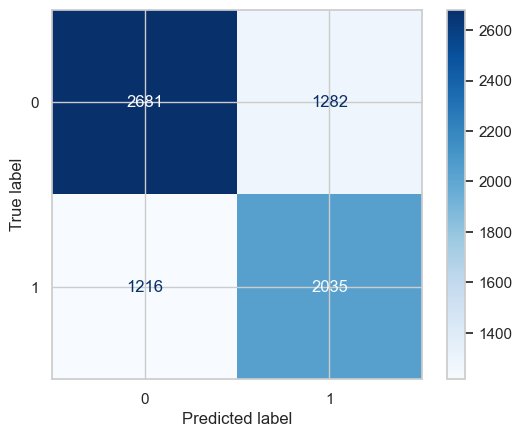

In [6]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
# lets plot the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

ROC-AUC: 0.702


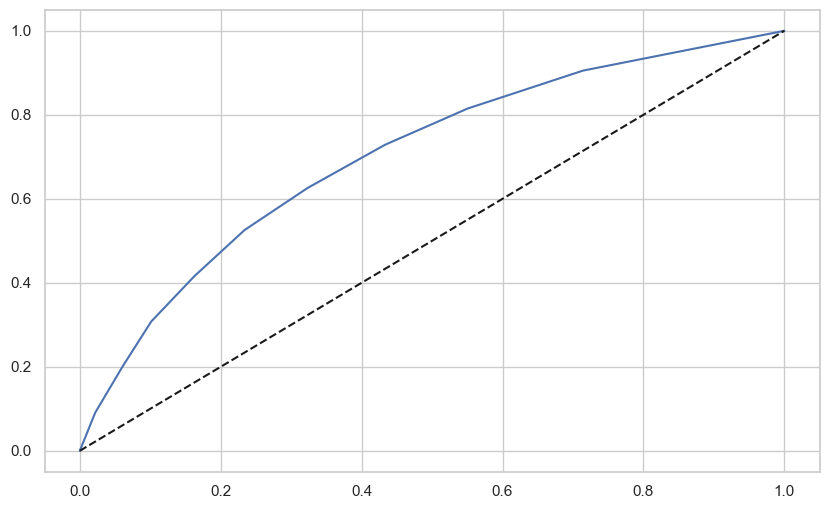

In [7]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_true, y_pred_decile)
print(f"ROC-AUC: {auc:.3f}")
# lets plot the roc curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_decile)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')


# Analysis by race

Performance Metrics by Race (COMPAS General):
            Race  Sample Size  Accuracy  Precision  Recall (TPR)   FPR  Recidivism Proportion
         Overall         7214     0.654      0.614         0.626 0.323                  0.451
African-American         3696     0.638      0.630         0.720 0.448                  0.514
       Caucasian         2454     0.670      0.591         0.523 0.235                  0.394
        Hispanic          637     0.661      0.542         0.444 0.215                  0.364
           Other          377     0.666      0.544         0.323 0.148                  0.353


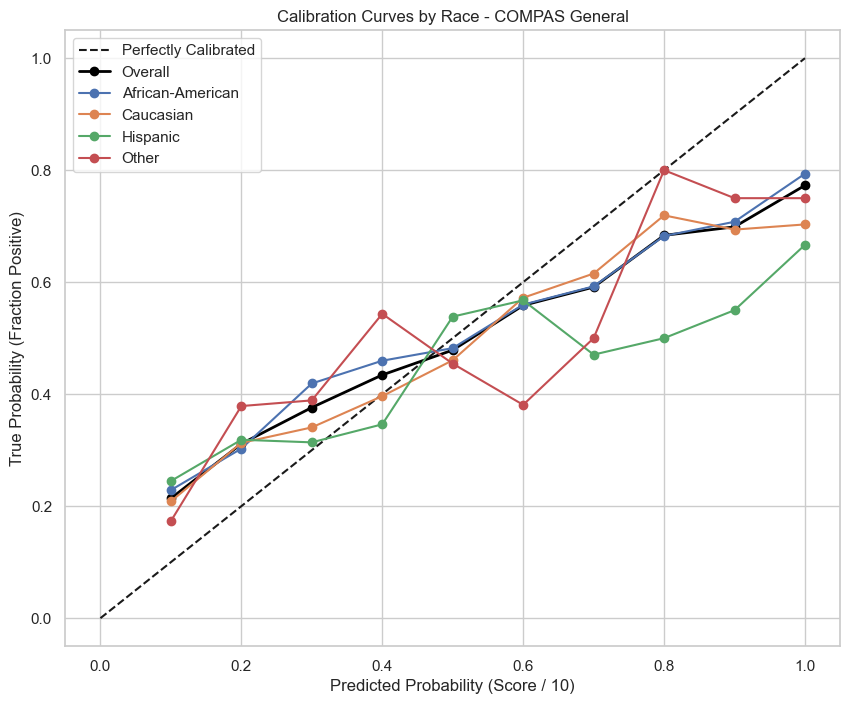

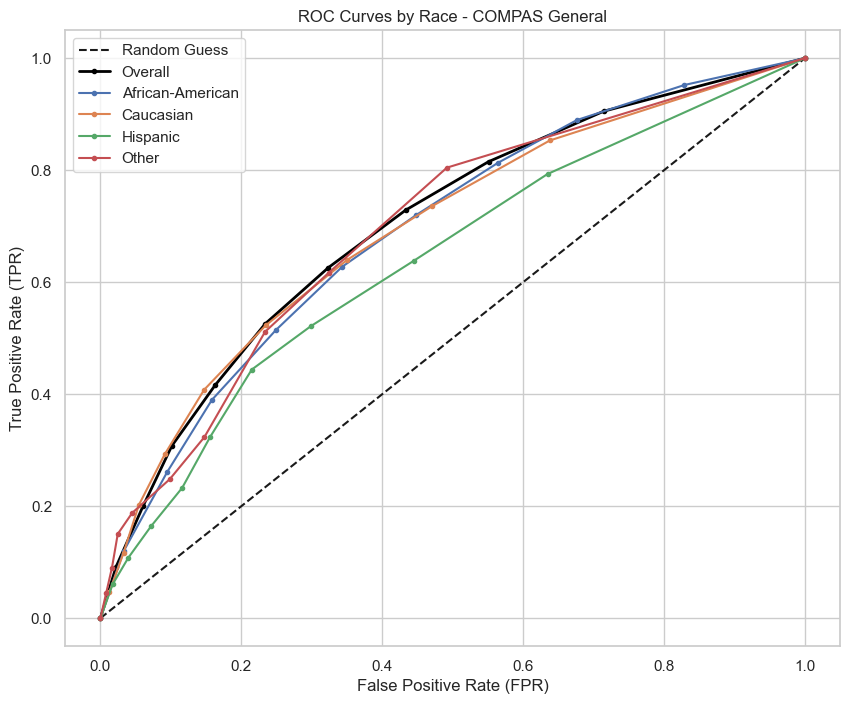

In [9]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def analyze_model_by_race(df, score_col='decile_score', true_col='two_year_recid', threshold=5, model_name='COMPAS'):
    """
    Analyze a model's performance by race, showing metrics, calibration, and ROC curves,
    with overall stats and lines for all races combined.
    
    Parameters:
    - df: DataFrame containing the dataset (e.g., COMPAS data).
    - score_col: Column name with model scores (default: 'decile_score').
    - true_col: Column name with true labels (default: 'two_year_recid').
    - threshold: Score threshold for binary prediction (default: 5).
    - model_name: Name of the model for plot titles (default: 'COMPAS').
    """
    # True labels and predicted binary outcomes
    y_true = df[true_col]
    y_pred_binary = (df[score_col] >= threshold).astype(int)  # Binary prediction
    y_pred_prob = df[score_col] / 10  # For calibration (0-1 scale)

    # Define races to analyze
    races = ['African-American', 'Caucasian', 'Hispanic', 'Other']

    # Initialize a dictionary to store metrics
    metrics_dict = {
        'Race': [],
        'Sample Size': [],
        'Accuracy': [],
        'Precision': [],
        'Recall (TPR)': [],
        'FPR': [],
        'Recidivism Proportion': []
    }

    # Compute metrics for overall (all races)
    accuracy_overall = accuracy_score(y_true, y_pred_binary)
    precision_overall = precision_score(y_true, y_pred_binary, zero_division=0)
    recall_overall = recall_score(y_true, y_pred_binary, zero_division=0)  # TPR
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    fpr_overall = fp / (fp + tn) if (fp + tn) > 0 else 0
    recidivism_prop_overall = y_true.mean()

    # Store overall results
    metrics_dict['Race'].append('Overall')
    metrics_dict['Sample Size'].append(len(df))
    metrics_dict['Accuracy'].append(accuracy_overall)
    metrics_dict['Precision'].append(precision_overall)
    metrics_dict['Recall (TPR)'].append(recall_overall)
    metrics_dict['FPR'].append(fpr_overall)
    metrics_dict['Recidivism Proportion'].append(recidivism_prop_overall)

    # Compute metrics by race
    for race in races:
        race_df = df[df['race'] == race]
        y_true_race = race_df[true_col]
        y_pred_race = (race_df[score_col] >= threshold).astype(int)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true_race, y_pred_race)
        precision = precision_score(y_true_race, y_pred_race, zero_division=0)
        recall = recall_score(y_true_race, y_pred_race, zero_division=0)  # TPR
        tn, fp, fn, tp = confusion_matrix(y_true_race, y_pred_race).ravel()
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        recidivism_prop = y_true_race.mean()
        
        # Store results
        metrics_dict['Race'].append(race)
        metrics_dict['Sample Size'].append(len(race_df))
        metrics_dict['Accuracy'].append(accuracy)
        metrics_dict['Precision'].append(precision)
        metrics_dict['Recall (TPR)'].append(recall)
        metrics_dict['FPR'].append(fpr)
        metrics_dict['Recidivism Proportion'].append(recidivism_prop)

    # Create and display DataFrame
    metrics_df = pd.DataFrame(metrics_dict)
    metrics_df = metrics_df.round(3)
    print(f"Performance Metrics by Race ({model_name}):")
    print(metrics_df.to_string(index=False))

    # Calibration curves by race + overall
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')

    # Overall calibration curve
    prob_true_all, prob_pred_all = calibration_curve(y_true, y_pred_prob, n_bins=10)
    plt.plot(prob_pred_all, prob_true_all, marker='o', color='black', linewidth=2, label='Overall')

    # Race-specific calibration curves
    for race in races:
        race_df = df[df['race'] == race]
        y_true_race = race_df[true_col]
        y_pred_race = race_df[score_col] / 10
        prob_true, prob_pred = calibration_curve(y_true_race, y_pred_race, n_bins=10)
        plt.plot(prob_pred, prob_true, marker='o', label=race)

    plt.xlabel('Predicted Probability (Score / 10)')
    plt.ylabel('True Probability (Fraction Positive)')
    plt.title(f'Calibration Curves by Race - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ROC curves by race + overall
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

    # Overall ROC curve
    fpr_all, tpr_all, _ = roc_curve(y_true, df[score_col])
    plt.plot(fpr_all, tpr_all, marker='.', color='black', linewidth=2, label='Overall')

    # Race-specific ROC curves
    for race in races:
        race_df = df[df['race'] == race]
        y_true_race = race_df[true_col]
        y_score_race = race_df[score_col]
        fpr, tpr, _ = roc_curve(y_true_race, y_score_race)
        plt.plot(fpr, tpr, marker='.', label=race)

    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curves by Race - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with COMPAS dataset
# if __name__ == "__main__":
#     # Load the dataset
#     df = pd.read_csv('compas-scores-two-years.csv')
    
    # Analyze default COMPAS model (decile_score, two_year_recid)
analyze_model_by_race(df, score_col='decile_score', 
                      true_col='two_year_recid', threshold=5, model_name='COMPAS General')
    
    # Example: Analyze violent recidivism model
    # analyze_model_by_race(df, score_col='v_decile_score', true_col='is_violent_recid', threshold=5, model_name='COMPAS Violent')

In [10]:
#     # Example: Analyze violent recidivism model (v_decile_score, is_violent_recid)
# analyze_model_by_race(df, score_col='v_decile_score', 
#                     #   true_col='is_violent_recid', 
#                       true_col='two_year_recid',
#                       threshold=5, model_name='COMPAS Violent')

# now with true col that is the same as the score col


In [11]:
df = df[(df["days_b_screening_arrest"] <= 30)
        & (df["days_b_screening_arrest"] >= -30)
        & (df["is_recid"] != -1)
        & (df["c_charge_degree"] != 'O')
        & (df["score_text"] != 'N/A')].reset_index(drop=True)

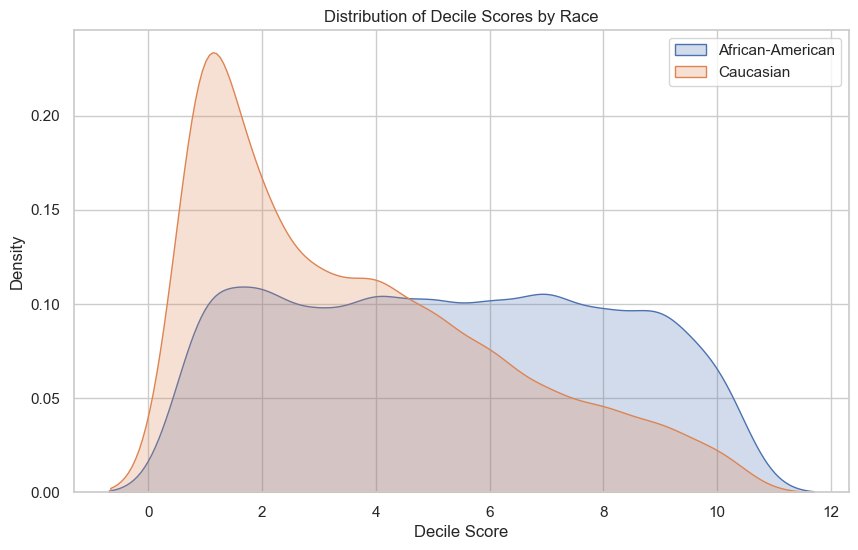

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data for subgroups
df_black = df[df["race"] == "African-American"]
df_white = df[df["race"] == "Caucasian"]

# Plot distributions
plt.figure(figsize=(10,6))
sns.kdeplot(df_black["decile_score"], fill=True, label="African-American")
sns.kdeplot(df_white["decile_score"], fill=True, label="Caucasian")

plt.title("Distribution of Decile Scores by Race")
plt.xlabel("Decile Score")
plt.ylabel("Density")
plt.legend()
plt.show()

# Lets build a classifier to predict the recidivism of a defendant based on the COMPAS score



## First a simple logreg

In [13]:
# Data prep
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load dataset
# df = pd.read_csv("compas-scores-two-years.csv")

# Preprocessing based on ProPublica criteria
df = df[(df['days_b_screening_arrest'] <= 30) &
        (df['days_b_screening_arrest'] >= -30) &
        (df['is_recid'] != -1) &
        (df['c_charge_degree'] != 'O') &
        (df['score_text'] != 'N/A')]

# Select relevant columns
features = ['age', 'sex', 'race', 'juv_fel_count', 'juv_misd_count',
            'juv_other_count', 'priors_count', 'c_charge_degree', 'days_b_screening_arrest',  'c_charge_desc']
target = 'two_year_recid'

X = df[features]
y = df[target]

# if a c_charge_desc is not in one of the top 10 charges, set it to "Other"
top_10_charges = X['c_charge_desc'].value_counts().head(10).index
X['c_charge_desc'] = X['c_charge_desc'].apply(lambda x: x if x in top_10_charges else "Other")




# Convert categorical variables using one-hot encoding
X = pd.get_dummies(X, columns=['sex', 'race', 'c_charge_degree','c_charge_desc'], drop_first=True)


# Scale numerical features
# scaler = StandardScaler()
# X[['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest']] = \
#     scaler.fit_transform(X[['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'days_b_screening_arrest']])

# After scaling step, explicitly convert all columns to numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Drop rows with any remaining NaNs after coercion
X.dropna(inplace=True)
y = y.loc[X.index]

# Re-split after cleaning
X_train, X_test, y_train, y_test = train_test_split(
    X.values.astype(float), y.values.astype(float), test_size=0.2, random_state=42
)

/var/folders/tb/hcgb8y4j1xz6h647gc988q980000gn/T/ipykernel_23076/1910309895.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['c_charge_desc'] = X['c_charge_desc'].apply(lambda x: x if x in top_10_charges else "Other")


Logistic Regression Accuracy: 0.6672
[1 0 0 ... 1 0 1]


/Users/fabio.casati/.venvs/3new/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


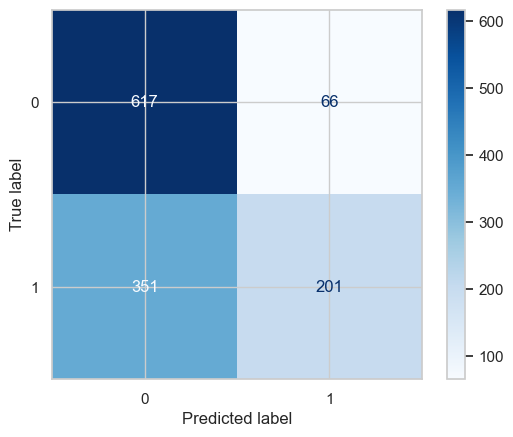

In [14]:
# lets train a simple logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Initialize the model
logistic_model = LogisticRegression()

# Train the model
logistic_model.fit(X_train, y_train)

# Evaluate the model
accuracy = logistic_model.score(X_test, y_test)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")

# lets visialuze hte confusion matrix. predict with y threshold of 0.6.
# get the probability of the positive class
y_pred_prob = logistic_model.predict_proba(X_test)[:, 1]
# set threshold to 0.6
y_pred = (y_pred_prob >= 0.6).astype(int)
# y_pred = logistic_model.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)


# print y_pred
print(y_pred)
# print y_test


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

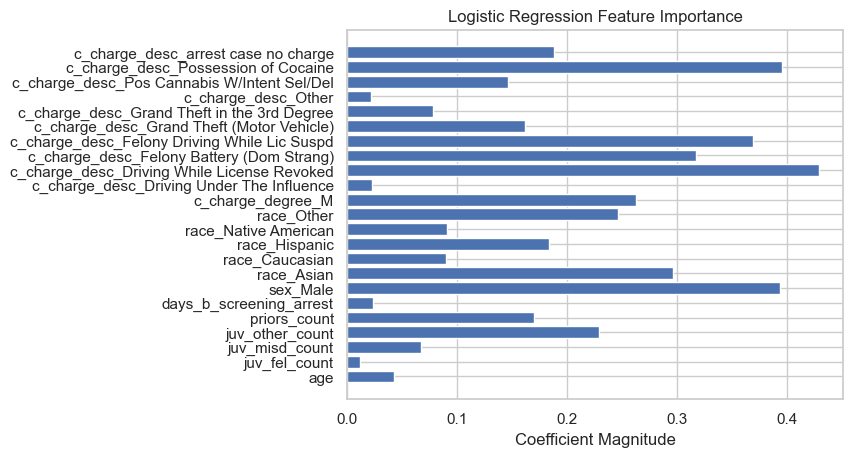

In [15]:
# lets visualize the importance of the features
import numpy as np
import matplotlib.pyplot as plt

coefficients = logistic_model.coef_[0]

# Plot absolute values of coefficients as importance
importance = np.abs(coefficients)
plt.barh(X.columns, importance)
plt.xlabel('Coefficient Magnitude')
plt.title('Logistic Regression Feature Importance')
plt.show()


## Counterfactuals

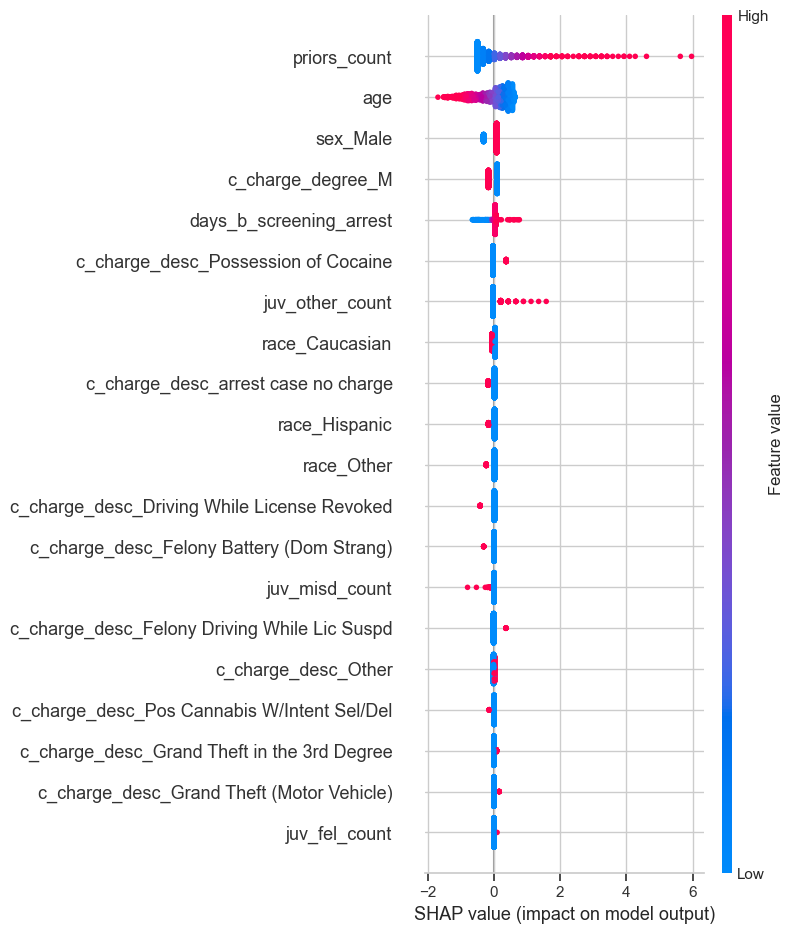

Top 5 Features by SHAP Value:
1. priors_count
2. age
3. sex_Male
4. c_charge_degree_M
5. days_b_screening_arrest

Example Index: 408
Example Prediction Probability: 0.4996
Example Prediction: 0
Original Age: 22.0
Original Prediction Probability: 0.4995601360266132
Original Prediction: 0
Counterfactual Age: 21.7

Counterfactual Prediction Probability: [0.50273856]
Counterfactual Prediction: 1.0


In [16]:
# now lets explore how we can create and identify counterfactuals
# we are looking for examples where the model prediction changes when we change a feature minimally
# we can use the SHAP library to do this
import shap

# Initialize the SHAP explainer
explainer = shap.Explainer(logistic_model, X_train)

# Calculate SHAP values
shap_values = explainer(X_test)

# Get the mean absolute SHAP values for each feature
shap_mean = np.abs(shap_values.values).mean(0)

# Sort the features by importance
sorted_idx = np.argsort(shap_mean)
sorted_features = X.columns[sorted_idx]

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# lets look at the top 5 features
top_features = sorted_features[-5:]
print(f"Top 5 Features by SHAP Value:")
for i, feature in enumerate(top_features[::-1]):
    print(f"{i+1}. {feature}")

# lets identify a counterfactual example, and show how by changing a feature slightly, the prediction changes
# Select an example close to the decision boundary
example_idx = np.argmin(np.abs(y_pred_prob - 0.5))
example = X_test[example_idx]
print(f"\nExample Index: {example_idx}")
print(f"Example Prediction Probability: {y_pred_prob[example_idx]:.4f}")
print(f"Example Prediction: {y_pred[example_idx]}")

# lets try to change the age slightly for this example
# print the oriigianl age
print(f"Original Age: {X_test[example_idx][0]}")
# print the original prediction
print(f"Original Prediction Probability: {y_pred_prob[example_idx]}")
print(f"Original Prediction: {y_pred[example_idx]}")

# Create a counterfactual example by changing the age slightly
x_counterfactual = X_test[example_idx].copy()
x_counterfactual[0] -= 0.3  # Change age by 0.1
x_counterfactual = x_counterfactual.reshape(1, -1)

# print the new age
print(f"Counterfactual Age: {x_counterfactual[0][0]}")



# Get the model prediction for the counterfactual example
pred_counterfactual = logistic_model.predict(x_counterfactual)
prob_counterfactual = logistic_model.predict_proba(x_counterfactual)[:, 1]
print(f"\nCounterfactual Prediction Probability: {prob_counterfactual}")
print(f"Counterfactual Prediction: {pred_counterfactual[0]}")





## Simple 2 layer model

In [17]:


# Now convert data to PyTorch tensors safely
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [18]:
X

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,sex_Male,race_Asian,race_Caucasian,race_Hispanic,...,c_charge_desc_Driving Under The Influence,c_charge_desc_Driving While License Revoked,c_charge_desc_Felony Battery (Dom Strang),c_charge_desc_Felony Driving While Lic Suspd,c_charge_desc_Grand Theft (Motor Vehicle),c_charge_desc_Grand Theft in the 3rd Degree,c_charge_desc_Other,c_charge_desc_Pos Cannabis W/Intent Sel/Del,c_charge_desc_Possession of Cocaine,c_charge_desc_arrest case no charge
0,69,0,0,0,0,-1.0,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,34,0,0,0,0,-1.0,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,24,0,0,1,4,-1.0,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,44,0,0,0,0,0.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,41,0,0,0,14,-1.0,True,False,True,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6167,23,0,0,0,0,-1.0,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
6168,23,0,0,0,0,-1.0,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
6169,57,0,0,0,0,-1.0,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
6170,33,0,0,0,3,-1.0,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [19]:
import torch.nn as nn
import torch.optim as optim

# Define the neural network model
class RecidivismModel(nn.Module):
    def __init__(self, input_dim):
        super(RecidivismModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(32, 16)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(self.relu(self.fc1(x)))
        x = self.dropout2(self.relu(self.fc2(x)))
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize model, loss function, and optimizer
model = RecidivismModel(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Train the model
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}')

    # Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_loss = 0
    total = 0
    correct = 0
    for inputs, labels in test_loader:
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        total += labels.size(0)
        correct += (outputs.round() == labels).sum().item()
    test_loss /= len(test_loader)
    accuracy = correct / total
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')

# Save the model
torch.save(model, 'recidivism_model.pth')


Epoch 1/30, Loss: 0.6449
Epoch 2/30, Loss: 0.6241
Epoch 3/30, Loss: 0.6136
Epoch 4/30, Loss: 0.6124
Epoch 5/30, Loss: 0.6150
Epoch 6/30, Loss: 0.6082
Epoch 7/30, Loss: 0.6093
Epoch 8/30, Loss: 0.6091
Epoch 9/30, Loss: 0.6113
Epoch 10/30, Loss: 0.6083
Epoch 11/30, Loss: 0.6068
Epoch 12/30, Loss: 0.6078
Epoch 13/30, Loss: 0.6018
Epoch 14/30, Loss: 0.6082
Epoch 15/30, Loss: 0.6065
Epoch 16/30, Loss: 0.6073
Epoch 17/30, Loss: 0.6064
Epoch 18/30, Loss: 0.6059
Epoch 19/30, Loss: 0.6054
Epoch 20/30, Loss: 0.6018
Epoch 21/30, Loss: 0.6054
Epoch 22/30, Loss: 0.6031
Epoch 23/30, Loss: 0.6053
Epoch 24/30, Loss: 0.6061
Epoch 25/30, Loss: 0.5995
Epoch 26/30, Loss: 0.6036
Epoch 27/30, Loss: 0.6011
Epoch 28/30, Loss: 0.6025
Epoch 29/30, Loss: 0.5969
Epoch 30/30, Loss: 0.6032
Test Loss: 0.6123, Accuracy: 0.6794


[1 0 1 0 0 0 1 1 1 0]
[1. 0. 0. 0. 0. 0. 1. 1. 1. 0.]
Test Accuracy: 67.94%
              precision    recall  f1-score   support

         0.0       0.69      0.76      0.72       683
         1.0       0.66      0.58      0.62       552

    accuracy                           0.68      1235
   macro avg       0.68      0.67      0.67      1235
weighted avg       0.68      0.68      0.68      1235



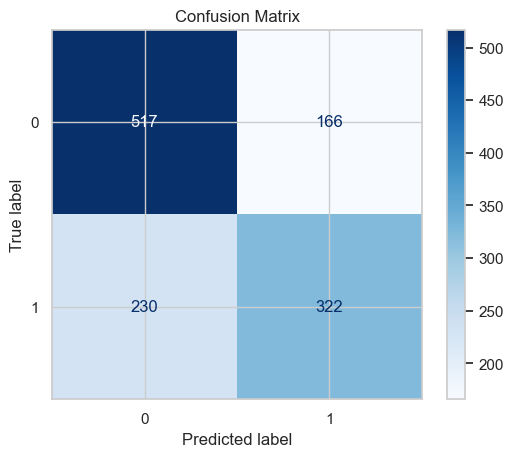

In [20]:
# show the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import accuracy_score, classification_report



# get the test set as a tensor
X_test = torch.tensor(X_test, dtype=torch.float32)

# Evaluate the predictions
y_pred = model(X_test).squeeze()

# detach and convert to numpy
y_pred = y_pred.detach().numpy()

# convert y_pred to 0 or 1
y_pred = (y_pred > 0.5).astype(int)

y_test = y_test

# print the first 10 predictions
print(y_pred[:10])
print(y_test[:10])

# Evaluate the predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.2%}')

# Detailed classification report
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()




In [21]:
# let's now analyze counterfactuals. lets take an example that is on the edge of the classification 
# threshold and we change a para,eter

In [22]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
# import matplotlib.pyplot as plt
# import seaborn as sns

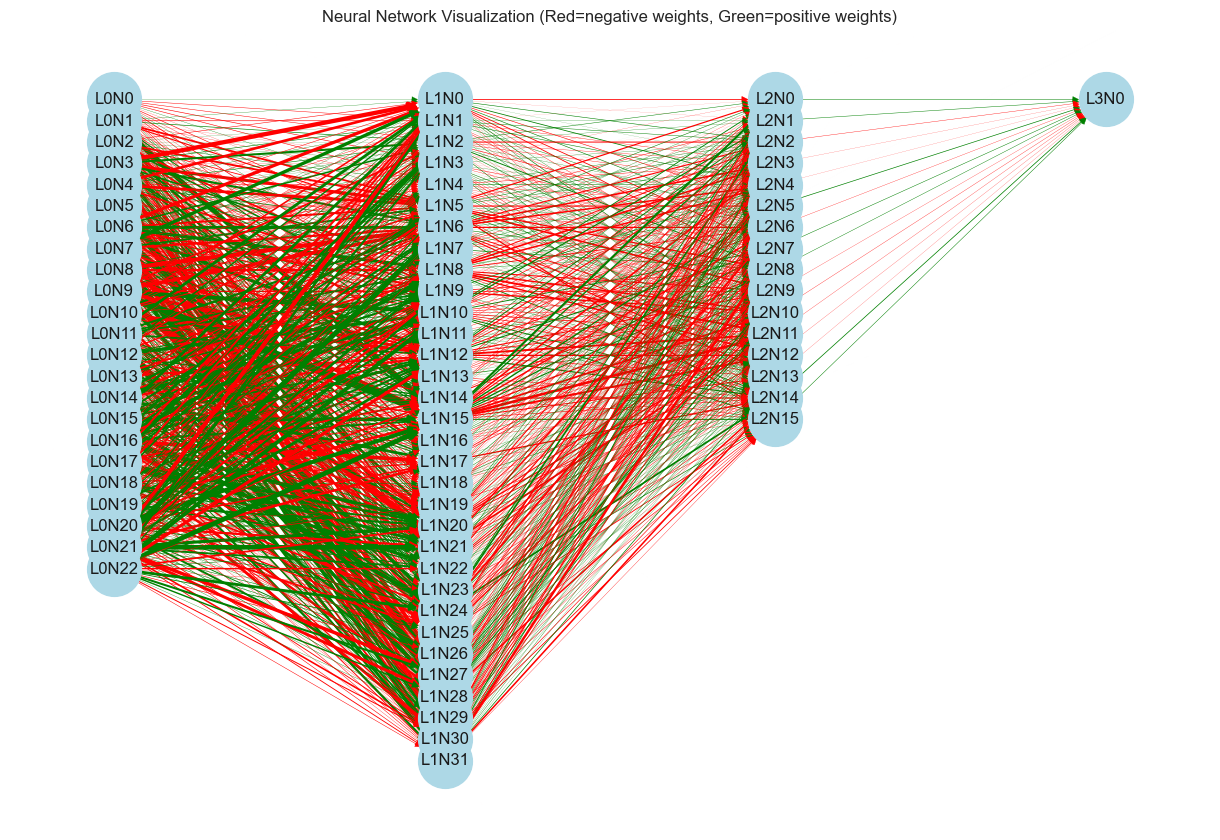

In [23]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Assume 'model' is your trained PyTorch neural network
# Extract weights
layers = [module for module in model.modules() if isinstance(module, torch.nn.Linear)]

G = nx.DiGraph()

# Create nodes for each layer
layer_sizes = [layers[0].in_features] + [layer.out_features for layer in layers]

node_labels = {}
node_count = 0
node_positions = {}

for l_idx, layer_size in enumerate(layer_sizes):
    for n in range(layer_size):
        node_labels[node_count] = f'L{l_idx}N{n}'
        node_positions[node_count] = (l_idx, -n)
        node_count += 1

# Create edges with weights as importance
node_offset = 0
for layer in layers:
    in_features = layer.in_features
    out_features = layer.out_features
    weights = layer.weight.detach().numpy()

    for i in range(in_features):
        for j in range(out_features):
            weight = weights[j, i]
            G.add_edge(node_offset + i, node_offset + in_features + j, weight=weight)
    node_offset += in_features

# Draw network
plt.figure(figsize=(12, 8))
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())

# Normalize edge widths by absolute weights
weights_norm = [abs(w)/np.max(np.abs(weights)) * 5 for w in weights]

nx.draw(G, pos=node_positions, with_labels=True, labels=node_labels, 
        node_color='lightblue', node_size=1500, 
        edgelist=edges, width=weights_norm, 
        edge_color=['red' if w < 0 else 'green' for w in weights])

plt.title("Neural Network Visualization (Red=negative weights, Green=positive weights)")
plt.show()


In [24]:
# # Filter data
# df = df[(df.days_b_screening_arrest <= 30) &
#         (df.days_b_screening_arrest >= -30) &
#         (df.is_recid != -1) &
#         (df.c_charge_degree != "O") &
#         (df.score_text != 'N/A')]

# # Add length of stay
# df['length_of_stay'] = (pd.to_datetime(df['c_jail_out']) - pd.to_datetime(df['c_jail_in'])).dt.days

# # Correlation between length_of_stay and decile_score
# print("Correlation:", df['length_of_stay'].corr(df['decile_score']))

# # Summary statistics
# print(df['age_cat'].value_counts())
# print(df['race'].value_counts())
# print(df['score_text'].value_counts())

# # Cross-tabulation
# print(pd.crosstab(df['sex'], df['race']))

# # Recidivism rate
# recid_rate = df[df['two_year_recid'] == 1].shape[0] / df.shape[0] * 100
# print(f"Recidivism Rate: {recid_rate:.2f}%")

# # Decile score distribution by race
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# sns.countplot(x='decile_score', data=df[df.race == "African-American"], ax=axes[0])
# axes[0].set_title("Black Defendant's Decile Scores")
# sns.countplot(x='decile_score', data=df[df.race == "Caucasian"], ax=axes[1])
# axes[1].set_title("White Defendant's Decile Scores")
# plt.tight_layout()
# plt.show()

# # Logistic regression model using statsmodels
# import statsmodels.api as sm

# # Prepare data for logistic regression
# df['score_factor'] = (df.score_text != "Low").astype(int)
# model_df = pd.get_dummies(df[['sex', 'age_cat', 'race', 'priors_count', 'c_charge_degree', 'two_year_recid']], drop_first=True)
# X = sm.add_constant(model_df)
# y = df['score_factor']

# # Fit logistic regression
# print(X.dtypes)
# print(X.isnull().sum())
# logit_model = sm.Logit(y, X).fit()
# print(logit_model.summary())

# # Survival analysis
# cox_data = pd.read_csv("./cox-parsed.csv")
# cox_data = cox_data[(cox_data.score_text != "N/A") & (cox_data.end > cox_data.start)]

# # Prepare data for Cox regression
# cox_data = pd.get_dummies(cox_data, columns=['race', 'score_text'], drop_first=True)

# cph = CoxPHFitter()
# cph.fit(cox_data, duration_col='end', event_col='event', start_col='start')
# cph.print_summary()

# # Kaplan-Meier survival curves
# kmf = KaplanMeierFitter()
# fig, ax = plt.subplots(figsize=(10, 6))
# for label, grouped_df in cox_data.groupby('score_text_Medium'):
#     kmf.fit(grouped_df['end'] - grouped_df['start'], event_observed=grouped_df['event'], label=f"Score {'Medium' if label else 'High'}")
#     kmf.plot_survival_function(ax=ax)

# ax.set_title("Kaplan-Meier Survival Curves")
# plt.show()


# COMPAS Dataset Column Descriptions

The COMPAS dataset, derived from the **Correctional Offender Management Profiling for Alternative Sanctions (COMPAS)** software developed by Northpointe (now Equivant), was analyzed by ProPublica in 2016 using data from Broward County, Florida. It’s widely studied in algorithmic fairness related to recidivism risk prediction, containing criminal history, demographics, jail/prison time, and COMPAS risk scores.

Below are key columns and their explanations:

| Column | Type | Meaning |
|--------|------|---------|
| `id` | Integer | Unique identifier for each defendant. |
| `name` | String | Defendant’s full name (often anonymized). |
| `sex` | Categorical ("Male", "Female") | Defendant’s gender, a protected attribute. |
| `age` | Integer | Defendant’s age at assessment. |
| `age_cat` | Categorical ("Less than 25", "25 - 45", "Greater than 45") | Age group categories. |
| `race` | Categorical ("African-American", "Caucasian", "Hispanic", "Asian", "Native American", "Other") | Defendant’s race. |
| `juv_fel_count` | Integer | Juvenile felony convictions count. |
| `juv_misd_count` | Integer | Juvenile misdemeanor convictions count. |
| `juv_other_count` | Integer | Other juvenile offenses count. |
| `priors_count` | Integer | Total prior adult convictions. |
| `c_charge_degree` | Categorical ("F" = felony, "M" = misdemeanor) | Current charge severity. |
| `c_charge_desc` | String | Description of the current charge. |
| `decile_score` | Integer (1-10) | General recidivism risk score (1 = low risk, 10 = high risk). |
| `score_text` | Categorical ("Low", "Medium", "High") | Simplified risk interpretation. |
| `is_recid` | Binary (0, 1, sometimes -1) | Recidivism indicator post-assessment. |
| `two_year_recid` | Binary (0, 1) | Recidivism within two years indicator. |
| `is_violent_recid` | Binary (0, 1) | Violent offense indicator post-assessment. |
| `days_b_screening_arrest` | Integer | Days between arrest and COMPAS assessment (filtered ±30 days). |
| `c_jail_in`, `c_jail_out` | Datetime | Jail entry and exit dates. |
| `v_decile_score` | Integer (1-10) | Violent recidivism risk score. |

### Additional Notes

- **Preprocessing**: Records outside ±30 days from arrest, with `is_recid` = -1, or charges labeled "O" are excluded.
- **Target Variable**: `two_year_recid` is commonly used to evaluate predictions.
- **Fairness**: `race` and `sex` are critical for bias analysis. ProPublica noted racial disparities, with higher false-positive rates for African-Americans and higher false-negative rates for Caucasians.

For additional details or questions, please ask!



In [25]:
# lets explore the charge description
print(df['c_charge_desc'].value_counts()[:10])





c_charge_desc
Battery                           1087
arrest case no charge              784
Possession of Cocaine              419
Grand Theft in the 3rd Degree      384
Driving While License Revoked      189
Driving Under The Influence        126
Pos Cannabis W/Intent Sel/Del       93
Felony Driving While Lic Suspd      93
Felony Battery (Dom Strang)         92
Grand Theft (Motor Vehicle)         92
Name: count, dtype: int64
